<a href="https://colab.research.google.com/github/tranbaquang1708/GraduationThesis/blob/irg_prototype/IRG_2d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
import os
mp = os.path.abspath(os.path.join('/content/drive/My Drive/GraduationThesis/gitrepo/GraduationThesis/'))
sys.path.append(mp)

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from modules import Rbf

In [4]:
def read_txt2(filename):
  onsurface_points = np.zeros((0,2))
  shifted_points = np.zeros((0,2)) # onsurface_points left shifted by 1
  first_point = np.zeros((1,2))
  last_point = np.zeros((1,2))

  with open(filename, 'r') as f:
    for c in range(int(f.readline())):
      num_of_verticles = int(f.readline())

      first_point[0] = np.loadtxt(f, max_rows=1)
      middle_points = np.loadtxt(f, max_rows=num_of_verticles-2)
      last_point[0] = np.loadtxt(f, max_rows=1)

      # Onsuface points order: first_point,middle_points,last_point
      # Shifted points order:  middle_points,last_point,first_point
      onsurface_points = np.concatenate((onsurface_points, first_point))    # Onsurface: first_point
      onsurface_points = np.concatenate((onsurface_points, middle_points))  # Onsurface: middle_points
      shifted_points = np.concatenate((shifted_points, middle_points))      # Shifted: middle_points
      # Remove the last point if it is the same as the first point
      if np.not_equal(last_point,first_point).any():
        onsurface_points = np.concatenate((onsurface_points,last_point))    # Onsurface: last_point
        shifted_points = np.concatenate((shifted_points,last_point))        # Shifted: last_point
      shifted_points = np.concatenate((shifted_points,first_point))         # Shifted: first_point

  # Vector of 2 consecutive points
  vectors = shifted_points - onsurface_points
  # Getting normal vectors
  norm = np.linalg.norm(vectors, axis=1)
  normal_vectors = np.ones_like(vectors)

  normal_vectors[:,0] = np.divide(-vectors[:,1],norm)
  normal_vectors[:,1] = np.divide(vectors[:,0],norm)

  return torch.from_numpy(onsurface_points).float(), torch.from_numpy(normal_vectors).float()

In [5]:
# Off surface points
filename = mp + '/dataset/2d/riderr.vert'
dataset, normal_vectors = read_txt2(filename)
# print(dataset)

In [187]:
class IGRPerceptron(nn.Module):
  def __init__(self):
    super(IGRPerceptron, self).__init__()
    self.fc1 = nn.Linear(2, 512)
    self.fc2 = nn.Linear(512, 512)
    self.fc3 = nn.Linear(512, 1)
    self.activation = nn.Softplus()

  def forward(self, x):
    out = self.fc1(x)
    # out = torch.flatten(out, 1)
    out = self.activation(out)
    out = self.fc2(out)
    out = self.activation(out)
    out = self.fc3(out)
    out = self.activation(out)
    return out

In [251]:
# loss = \sum_I (w^T*x_i)^2 + 0.1 * (||w||^2 - 1)^2
def irg_loss(x, w):
  # w^T*x_1 = w_x1 * x_1 + w_y1 * y_1 + w_x2 * x_1 + w_y2 * y_1 + ... + w_xn * x_1 + w_yn * y_1
  # return torch.sum(torch.square(torch.sum(torch.sum(w*x[:,None], dim=1), dim=1))) + 0.1*torch.square(torch.square(torch.norm(w)-1))

  # w^t * x_1 = w_1 * x_1 + w_2 * x_1 + ... + w_n * x_1 
  d = torch.sqrt(torch.sum(torch.square(x - x[:, None]), dim=2)) #pdist squareform
  return torch.sum(torch.square(torch.sum(w*d, dim=0))) + 0.1*torch.square(torch.square(torch.norm(w)-1))

In [259]:
my_nn = IGRPerceptron()
optimizer = torch.optim.Adam(my_nn.parameters())

for i in range(5000): 
  result = my_nn(dataset)
  loss = irg_loss(dataset, result)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

print(loss)
# print(result)

tensor(0.1000, grad_fn=<AddBackward0>)


In [260]:
def sampling(x, w, xx, yy):
  dimw = w.shape
  dimg = xx.shape
  z = np.zeros(dimg)

  # g = np.concatenate((xx, yy), axis=1)
  # print(xx.shape)
  # t = w[None, 0] * xx
  # print(t)
  for k in range(int(dimw[0])):
    z += w[k] * np.sqrt((xx - x[k,0])**2 + (yy - x[k,1])**2)
    # z += np.sqrt(np.square(w[i] * (xx-dataset) + np.square(w[i] * yy))
    # z += np.square(w[i,0] * (xx-dataset.numpy()[i,0]) + w[i,1]*(yy-dataset.numpy()[i,1]))
  # z = np.square(w[:,0]*xx[:] + w[:,1]*yy[:])
  # z = np.sum(np.sum(np.square(w*g[:, None]), axis=1), axis=1)
  # print(t.shape)
  return np.square(z)

In [261]:
xx,yy = Rbf.grid(dataset[:,0].numpy(), dataset[:,1].numpy())
# z = sampling(result.detach().numpy(), xx ,yy)
z = sampling(dataset.numpy(), result.detach().numpy(), xx, yy)
print(z)

[[3.59951251e-15 3.45890287e-15 3.32708009e-15 ... 6.40315833e-15
  6.67564937e-15 6.95708249e-15]
 [3.39099040e-15 3.25049274e-15 3.11879039e-15 ... 6.19460965e-15
  6.46717418e-15 6.74868017e-15]
 [3.19237499e-15 3.05199151e-15 2.92041366e-15 ... 5.99615883e-15
  6.26880313e-15 6.55038744e-15]
 ...
 [4.72136805e-15 4.58219789e-15 4.45198916e-15 ... 7.63194176e-15
  7.90391520e-15 8.18477208e-15]
 [4.98947882e-15 4.85023915e-15 4.71994610e-15 ... 7.89997828e-15
  8.17198893e-15 8.45287760e-15]
 [5.26755686e-15 5.12824603e-15 4.99786874e-15 ... 8.17798327e-15
  8.45003373e-15 8.73095706e-15]]


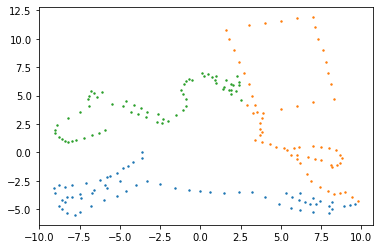

/content/drive/My Drive/GraduationThesis/gitrepo/GraduationThesis/modules/Rbf.py:149: UserWarning: No contour levels were found within the data range.
  h_object = plt.contour(xx,yy, z, levels=[0.0], colors='c')


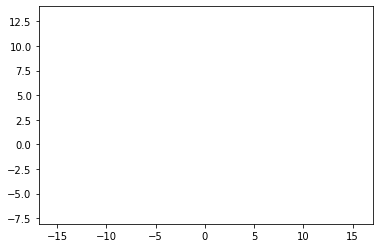

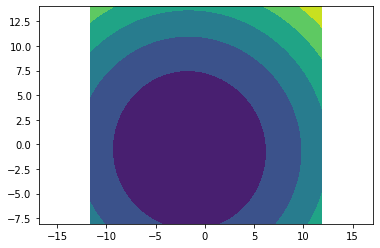

In [262]:
Rbf.visualize2(dataset, normal_vectors, xx, yy, z, scatter=True, vecfield=False, surface=True, offsurface=False, filled_contour=True)

In [263]:
# x = torch.tensor([[5, 3], [2, 1], [3,2]], dtype=torch.float)
# y = torch.tensor([[1,1], [1,2], [3,2]], dtype=torch.float)

# x = x.numpy()
# y = y.numpy()

# t = np.concatenate((x,y), axis = 1)

# # t = torch.matmul(torch.transpose(x, 0, 1),y)
# # t = torch.matmul(x[:, :], y[:,:)])
# # t = x * y [:, None]
# # t = torch.cat((x,y), dim=1)
# # t = t.numpy()
# # t = np.sum(t, axis=1)
# # t = np.sum(t, axis=1)

# print(t)

In [264]:
x = torch.tensor([[5, 3], [2, 1], [3,2]], dtype=torch.float)
y = torch.tensor([[1,1], [1,2], [2,3]], dtype=torch.float)
w = torch.tensor([[5], [2], [1]], dtype=torch.float)

# t = np.concatenate((x,y), axis = 1)

# t = torch.matmul(torch.transpose(x, 0, 1),y)
# t = torch.matmul(x[:, :], y[:,:)])
t = x - y [:, None]
# t = torch.cat((x,y), dim=1)
# t = t.numpy()
t = torch.sum(t, dim=2)
t = w*t
t = torch.sum(t, dim=0)

print(t)

tensor([43.,  3., 19.])


In [265]:
x = torch.tensor([[5], [2], [1], [3],[2]], dtype=torch.float)
y = torch.tensor([1, 2, 3, 4], dtype=torch.float)

# t = x[None, :] * y[:, None]
t = x * y
t = torch.sum(t, dim=0)
print(t)

tensor([13., 26., 39., 52.])
